In [45]:
from google.colab import drive
import numpy as np
import pandas as pd
import statsmodels.api as sm

drive.mount("/content/gdrive")  
!pwd  # show current path 

%cd "/content/gdrive/MyDrive/IA95022"
!ls  # show current directory

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/IA95022
/content/gdrive/MyDrive/IA95022
 bezdekIris.data	      notebookdc8e90834b.ipynb
 class_060922_starter.ipynb   spark_ml
 DryBeanDataset		     'Store Sales'
 Index			      train.csv
 Indicadores.csv	      tutorial_checkpoints
 Indicadores.xlsx	      tutorial_checkpoints_best
 iris.data		      us2022q2a.csv
 iris.names		      usfirms2022.csv
'Modulo 4'		      Wine


# Carga de datos (importado del entregable anterior)

In [46]:
# Carga de datos
usdata = pd.read_csv('us2022q2a.csv')
usfirms = pd.read_csv('usfirms2022.csv')
# Unimos la información de ambos datasets en un solo dataframe
usfirms.columns = usfirms.columns.str.replace('Ticker', 'firm')
df = pd.merge(usfirms, usdata, on="firm")

# Se obtienen los valores calculados 
df['qdate'] = pd.PeriodIndex(df['q'], freq="Q")
df.set_index(['firm', 'qdate'], drop = True)
df = df.replace(0,np.nan)
df['lprice'] = df.groupby(['firm'])['adjprice'].shift(4)
df['r'] = np.log(df['adjprice']) - np.log(df['lprice'])
df['r2']= np.log(df['adjprice']) - np.log(df.groupby(['firm'])['adjprice'].shift(4))
df.loc['ADT': 'ADTN', ['adjprice', 'lprice', 'r', 'r2']].iloc[85:96,]
df[['q', 'adjprice', 'lprice']]
df.loc['ADT': 'ADTN', ['adjprice', 'lprice']].iloc[84:98]
df["ReturnOnNextQuarter"] = df.groupby(["firm"])["r2"].shift(-1)
# Calculamos las variables para cada instancia de los datos
df['Book'] = df['totalassets'] - df['totalliabilities']
df['Market'] = df['originalprice'] * df['sharesoutstanding']
df['Market'] = df['Market'].fillna(0)
df["Ebit"] = df["revenue"] - df["cogs"] - df["sgae"] - df["otheropexp"]
df["OPM"] = df["Ebit"] / df["revenue"]
df["Net income"] = df["Ebit"] - df["incometax"] - df["finexp"]
df["Profit margin"] = df["Net income"] / df["revenue"]

In [47]:
from scipy.stats.mstats import winsorize
# Seleccionamos solo los valores que nos serán de utilidad en este análisis
rslt_df = df.loc[df["Sector NAICS\nlevel 1"].isin(['Finance and Insurance', 'Real Estate and Rental and Leasing'  ])]
df_analysis = rslt_df[['firm','q','r2', 'originalprice', 'ReturnOnNextQuarter', 'cogs', 'sgae', 'otheropexp', 'revenue', 'Ebit','OPM', 'Book', 'Market', 'Profit margin']]
mask = df_analysis['q']=='2022q1' 
df_analysis = df_analysis[mask]
# Calculamos las nuevas variables 
# Primero llenamos los NaN en todos los valores nulos en los divisores

df_analysis["Ebit"] = df["Ebit"].fillna(0)
df_analysis["OPM"] = df["Ebit"] / df["revenue"]
df_analysis['BookToMarketRatio'] = df['Book'] / df['Market']
df_analysis['ShortFinancialLeverage'] = df["shortdebt"] / df["totalassets"] 
df_analysis['LongFinancialLeverage'] = df["longdebt"] / df["totalassets"] 
df_analysis['OperatingProfitGrowth'] = (df["Ebit"] - df["Ebit"].shift(4)) - 1
df_analysis['SalesAnnualGrowth'] = (df["revenue"] / df["revenue"].shift(4)) - 1 
df_analysis['EPS'] = df["Net income"] / df["sharesoutstanding"]
df_analysis["lprice"] = df["lprice"].fillna(0)
df_analysis['EPSP'] =  df_analysis["EPS"] / df_analysis["originalprice"]
df_analysis['Size'] =  df["Market"].fillna(0)

# Aplicamos la winzorización a nuestros ratios
df_analysis["OPM"] = winsorize(df_analysis["OPM"], limits=[0.0001, 0.02])
df_analysis["BookToMarketRatio"] = winsorize(df_analysis["BookToMarketRatio"], limits=[0.0001, 0.02])
df_analysis["ShortFinancialLeverage"] = winsorize(df_analysis["ShortFinancialLeverage"], limits=[0.0001, 0.02])
df_analysis["OperatingProfitGrowth"] = winsorize(df_analysis["OperatingProfitGrowth"], limits=[0.0001, 0.02])
df_analysis["EPSP"] = winsorize(df_analysis["EPSP"], limits=[0.0001, 0.02])
df_analysis["OperatingProfitGrowth"] = winsorize(df_analysis["OperatingProfitGrowth"], limits=[0.0001, 0.02])
df_analysis["SalesAnnualGrowth"] = winsorize(df_analysis["SalesAnnualGrowth"], limits=[0.0001, 0.02])


df_analysis

,firm,q,r2,originalprice,ReturnOnNextQuarter,cogs,sgae,otheropexp,revenue,Ebit,...,Profit margin,BookToMarketRatio,ShortFinancialLeverage,LongFinancialLeverage,OperatingProfitGrowth,SalesAnnualGrowth,EPS,lprice,EPSP,Size
448,SRCE,2022q1,-0.002536,46.25,0.003602,2431.000,0.000,0.000,62049.000,0.0,...,0.0,0.803243,0.000000,0.016016,0.0,-0.003901,0.0,45.729730,0.0,1.144697e+06
2695,ACTG,2022q1,-0.388320,4.51,-0.293617,0.000,22015.000,0.000,13507.000,0.0,...,0.0,1.648238,0.254991,0.003474,0.0,1.327589,0.0,6.650000,0.0,2.096008e+05
3055,AKR,2022q1,0.162206,21.67,-0.307229,0.000,70280.000,-28815.000,81507.000,0.0,...,0.0,1.187334,0.000000,0.404709,0.0,0.174554,0.0,18.220675,0.0,2.028246e+06
4135,ACNB,2022q1,0.211581,34.95,0.095438,1024.000,0.000,0.000,18077.000,0.0,...,0.0,0.843972,0.000000,0.012156,0.0,-0.066753,0.0,28.063857,0.0,3.033382e+05
7645,AFCG,2022q1,-0.009163,19.12,-0.194946,0.000,1144.444,5236.604,16935.738,0.0,...,0.0,0.891454,0.000000,0.218182,0.0,2.614882,0.0,18.646623,0.0,3.774850e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318054,WETF,2022q1,-0.043822,5.87,-0.181233,0.000,60679.000,0.000,78368.000,0.0,...,0.0,0.294466,0.000244,0.319127,0.0,0.076040,0.0,6.064555,0.0,8.604615e+05
318684,WRLD,2022q1,0.390975,191.84,-0.356033,11043.938,0.000,0.000,166329.470,0.0,...,0.0,0.297036,0.000000,0.640112,0.0,0.137064,0.0,129.760000,0.0,1.255824e+06
319044,WSFS,2022q1,-0.055356,46.62,-0.139224,5579.000,0.000,0.000,144137.000,0.0,...,0.0,0.826064,0.000000,0.018014,0.0,0.188455,0.0,48.963914,0.0,3.047967e+06
319584,XELB,2022q1,-0.289359,1.49,-0.929759,1680.000,10065.000,32.000,8747.000,-3030.0,...,0.0,2.442752,0.028656,0.258356,-545.0,0.120118,0.0,1.990000,0.0,2.916097e+04


In [48]:
# En este código lo que se hace es regresar el valor del percentil con respecto al set de datos que recibe la función.
# Esta función va a recibir uno por uno cada quarter, lo que nos hara que regrese el valor del percentil para cada instancia 
# CON RESPECTO A SU QUARTER, NO CON RESPECTO A TODO EL SET DE DATOS

def dense_inclusive_pct(x):
    r = x.rank(method='dense') - 1
    return r / r.max() * 100

# Aqui mandamos a llamar dicha funcion de tal forma que se llame para cada quarter
df_analysis["pct"]=df_analysis.groupby('q').Market.apply(dense_inclusive_pct).astype(int)
# Aqui genero las variables dummies en base a lo mencionado previamente.
df_analysis["small?"] = df_analysis.pct <= 33
df_analysis["small?"] = df_analysis["small?"].astype(int)
df_analysis["medium?"] = (df_analysis.pct <= 66) & (df_analysis.pct > 33) 
df_analysis["medium?"] = df_analysis["medium?"].astype(int)

In [49]:
df_analysis.columns

Index(['firm', 'q', 'r2', 'originalprice', 'ReturnOnNextQuarter', 'cogs',
       'sgae', 'otheropexp', 'revenue', 'Ebit', 'OPM', 'Book', 'Market',
       'Profit margin', 'BookToMarketRatio', 'ShortFinancialLeverage',
       'LongFinancialLeverage', 'OperatingProfitGrowth', 'SalesAnnualGrowth',
       'EPS', 'lprice', 'EPSP', 'Size', 'pct', 'small?', 'medium?'],
      dtype='object')

In [50]:
#add constant to predictor variables
X = df_analysis[["EPSP", "OPM", "LongFinancialLeverage", "small?", "medium?"]]

y = df_analysis["ReturnOnNextQuarter"]

# Análisis exploratorio de las variables


## Matriz de varianza y covarianza

La varianza es una medida de dispersión que nos indica que tanto cambia un conjunto de datos comparado con su promedio. Nos es muy útil para darnos una idea del poder explicativo del promedio, ya que si la varianza es baja entonces el promedio nos da una imagen muy clara de qué podemos obtener al tomar cualquier valor del set de datos.

En derivado, la covarianza es el valor que refleja en qué medida dos variables aleatorias varían de forma conjunta respecto a sus medias.

La covarianza se obtiene al aplicar el concepto de varianza a dos conjuntos diferentes de datos. Nos ayuda a contestar preguntas como: ¿Qué pasa con X cuando Y incrementa? 

A continuación, se obtendrá una matriz que incluya los valores de la varianza y covarianza obtenidos al comparar entre sí las distintas variables en nuestro set de datos.

In [51]:
#Implementamos manualmente la obtención de la matriz de varianza y covarianza
import numpy as np
def matriz_var_cov(X):
  #Obtenemos la diferencia entre X y su promedio
  X-= X.mean(axis=1)[:,None]
  #Guardamos la cantidad de filas/instancias de datos en una variable
  N = X.shape[1] - 1
  #Ahora utilizaremos una fórmula de álgebra matricial para obtener las varianzas y covarianzas.
  #Tomaremos la matriz de diferencias con el promedio y la transpondremos. Después, obtenemos su 
  #complex conjugate.  
  #Después obtendremos el producto punto de la matriz de diferencias y la matriz calculada previamente.
  #El resultado lo dividiremos entre la cantidad de datos, y habremos obtenido la matriz de varianzas y covarianzas 
  return np.dot(X, X.T.conj())/float(N)

In [52]:
#Usamos una variable temporal para transponer nuestras variables X, y convertilas en un array de numpy
temp= X.T.to_numpy()

In [53]:
# Obtenemos nuestra matriz de varianzas y covarianzas usando la función que se implementó previamente
my_variance_covariance_matrix = matriz_var_cov(temp)

#La convertimos en un dataframe para su mejor visualización
my_variance_covariance_matrix_df = pd.DataFrame(my_variance_covariance_matrix)
my_variance_covariance_matrix_df

,0,1,2,3,4
0,0.000094,0.000554,-0.000171,-0.000458,-0.000023
1,0.000554,0.073277,0.003744,0.000962,-0.006919
2,-0.000171,0.003744,0.053365,-0.024379,0.012632
3,-0.000458,0.000962,-0.024379,0.226549,-0.113049
4,-0.000023,-0.006919,0.012632,-0.113049,0.220149


In [54]:
#Validamos la matriz de varianza y covarianza utilizando la función cov de pandas
test = X.cov()
test

,EPSP,OPM,LongFinancialLeverage,small?,medium?
EPSP,0.000094,0.000554,-0.000171,-0.000458,-0.000023
OPM,0.000554,0.073277,0.003744,0.000962,-0.006919
LongFinancialLeverage,-0.000171,0.003744,0.053365,-0.024379,0.012632
small?,-0.000458,0.000962,-0.024379,0.226549,-0.113049
medium?,-0.000023,-0.006919,0.012632,-0.113049,0.220149


## Matriz de correlación

La correlación es una medida que determina el grado de asociación que tiene el cambio de dos variables. En este caso particular, hablaremos de la correlación en relaciones lineales de dos variables: el coeficiente de correlación de Pearson.
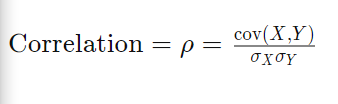

En la fórmula podemos ver que la correlación entre dos variables se obtiene dividiendo la covarianza de estas entre el producto de sus desviacioens estándar.
A continuación, usaremos como base la matriz que de varianza y covarianza que se construyó para poder armar una matriz de correlaciones.

In [55]:
#Creamos la matriz de correlación a partir de la matriz de varianza y covarianza obtenida

my_corr_matrix = np.zeros((len(my_variance_covariance_matrix),len(my_variance_covariance_matrix[0]) ))
my_corr_matrix



array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [56]:
# Ahora creamos una función que, para cada valor de la matriz de varianzas, va a calcular
# la correlación entre las variables de los indices i,j de la matriz

for i in range (0, len(my_corr_matrix)):
  for j in range (0, len(my_corr_matrix)):
    #definimos la varianza actual a procesar
    variance =  my_variance_covariance_matrix[i][j]
    #obtenemos las desviaciones estandar para las variables i, j 
    std_x = my_variance_covariance_matrix[i][i] ** (1/2)
    std_y = my_variance_covariance_matrix[j][j] ** (1/2)
    #ahora aplicamos la fórmula directamente
    my_corr_matrix[i][j] = variance / (std_x * std_y)


In [57]:
# Una vez armada la matriz, la convertimos en dataframe para su mejor visualización
my_corr_matrix_df = pd.DataFrame(my_corr_matrix)
my_corr_matrix_df.transpose()

,0,1,2,3,4
0,1.000000,0.211005,-0.076056,-0.099160,-0.005024
1,0.211005,1.000000,0.059874,0.007469,-0.054473
2,-0.076056,0.059874,1.000000,-0.221721,0.116547
3,-0.099160,0.007469,-0.221721,1.000000,-0.506208
4,-0.005024,-0.054473,0.116547,-0.506208,1.000000


In [58]:
#Ahora corroboramos el resultado utilizando la función .corr de Pandas
corr = X.corr()
corr

,EPSP,OPM,LongFinancialLeverage,small?,medium?
EPSP,1.000000,0.211005,-0.076056,-0.099160,-0.005024
OPM,0.211005,1.000000,0.059874,0.007469,-0.054473
LongFinancialLeverage,-0.076056,0.059874,1.000000,-0.221721,0.116547
small?,-0.099160,0.007469,-0.221721,1.000000,-0.506208
medium?,-0.005024,-0.054473,0.116547,-0.506208,1.000000


En nuestra matriz de correlaciones podemos observar que existe una correlación de 0.21 entre el EPSP y el OPM. La presencia de correlaciones como esta nos indica que vamos por buen camino, ya que la correlación no es lo suficientemente alta como para sospechar de un problema de multicolinearidad (esto lo evaluaremos más adelante), pero sigue siendo un valor que nos indica que existe una relación entre las variables que aportará valor a nuestro modelo.

## Análisis de outliers y leverage points

### Leverage Points

Un punto de apalancamiento, o leverage point en inglés, hace referencia a un dato que se sale mucho de lo observado en el dataset. La presencia de estos valores extremos puede influenciar en gran medida el resultado del modelo, posiblemente provocando una reducción en la precisión del modelo. 

A continuación se hará una visualización de los puntos de apalancamiento en nuestros datos utilizando álgebra matricial. 

In [59]:
X_tmp = df_analysis[["EPSP", "OPM", "LongFinancialLeverage", "small?", "medium?"]]
y_tmp = df_analysis["ReturnOnNextQuarter"]

Text(0.5, 1.0, 'Leverage Values (obtained with matrix algebra)')

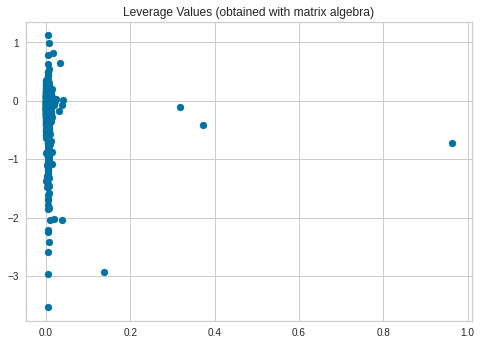

In [60]:
df_tmp = df_analysis
df_tmp['l'] = np.diagonal(np.dot(np.dot(X, np.linalg.inv(X.T @ X)), X.T))
import matplotlib.pyplot as plt
plt.scatter(df_tmp['l'], y_tmp)
plt.title("Leverage Values (obtained with matrix algebra)")

Ahora validaremos nuestra visualización de leverage points apoyándonos de la librería statsmodels 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Text(0.5, 1.0, 'Leverage Values (obtained with statsmodels framework)')

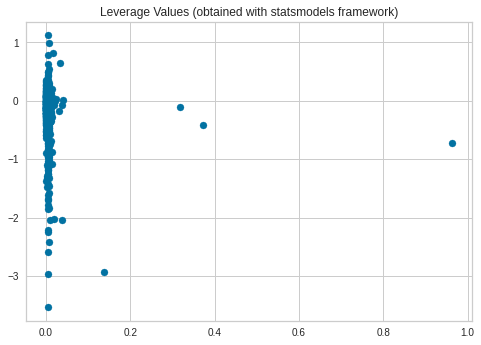

In [61]:
X = df_analysis[["EPSP", "OPM", "LongFinancialLeverage", "small?", "medium?"]]
x = sm.add_constant(X)
y = df_analysis["ReturnOnNextQuarter"]
m = sm.OLS(y, X).fit()

influence_values = m.get_influence()
l = influence_values.hat_matrix_diag

plt.scatter(l, y)
plt.title("Leverage Values (obtained with statsmodels framework)")

Ahora que validamos que nuestro procedimiento es correcto, podemos proceder al tratamiento de estos leverage points. Una thumb rule muy importante es que para que un leverage point sea considerado alto, este debe ser mayor al valor de 3 veces la media. 

In [62]:
leverage = pd.DataFrame(l)
leverage.describe()

,0
count,769.000000
mean,0.006502
std,0.039151
min,0.000000
25%,0.003416
50%,0.004011
75%,0.004846
max,0.962274


Vemos que tenemos una media de 0.006, por lo que nuestro límite para tolerar un leverage point será de 0.019 siguiendo el thumb rule de utilizar 3 veces la media como tolerancia. 

A continuación, agregaremos los leverage values al dataset para posteriormente hacer el filtrado

In [63]:
df_analysis["leverage"] = l 

In [64]:
lev_filter = df_analysis['leverage'] <= 0.019
df_analysis = df_analysis[lev_filter]
df_analysis

,firm,q,r2,originalprice,ReturnOnNextQuarter,cogs,sgae,otheropexp,revenue,Ebit,...,SalesAnnualGrowth,EPS,lprice,EPSP,Size,pct,small?,medium?,l,leverage
448,SRCE,2022q1,-0.002536,46.25,0.003602,2431.000,0.000,0.000,62049.000,0.0,...,-0.003901,0.0,45.729730,0.0,1.144697e+06,44,0,1,0.004805,0.004805
2695,ACTG,2022q1,-0.388320,4.51,-0.293617,0.000,22015.000,0.000,13507.000,0.0,...,1.327589,0.0,6.650000,0.0,2.096008e+05,16,1,0,0.003997,0.003997
3055,AKR,2022q1,0.162206,21.67,-0.307229,0.000,70280.000,-28815.000,81507.000,0.0,...,0.174554,0.0,18.220675,0.0,2.028246e+06,56,0,1,0.004710,0.004710
4135,ACNB,2022q1,0.211581,34.95,0.095438,1024.000,0.000,0.000,18077.000,0.0,...,-0.066753,0.0,28.063857,0.0,3.033382e+05,21,1,0,0.003964,0.003964
7645,AFCG,2022q1,-0.009163,19.12,-0.194946,0.000,1144.444,5236.604,16935.738,0.0,...,2.614882,0.0,18.646623,0.0,3.774850e+05,24,1,0,0.004064,0.004064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318054,WETF,2022q1,-0.043822,5.87,-0.181233,0.000,60679.000,0.000,78368.000,0.0,...,0.076040,0.0,6.064555,0.0,8.604615e+05,39,0,1,0.004210,0.004210
318684,WRLD,2022q1,0.390975,191.84,-0.356033,11043.938,0.000,0.000,166329.470,0.0,...,0.137064,0.0,129.760000,0.0,1.255824e+06,46,0,1,0.007601,0.007601
319044,WSFS,2022q1,-0.055356,46.62,-0.139224,5579.000,0.000,0.000,144137.000,0.0,...,0.188455,0.0,48.963914,0.0,3.047967e+06,63,0,1,0.004789,0.004789
319584,XELB,2022q1,-0.289359,1.49,-0.929759,1680.000,10065.000,32.000,8747.000,-3030.0,...,0.120118,0.0,1.990000,0.0,2.916097e+04,1,1,0,0.006780,0.006780


### Outliers 

Los outliers son valores que no suelen seguir la tendencia general de los datos, por lo que su presencia puede generar ruido y reducir la precisión de los modelos. 

Existen distintas pruebas que se pueden realizar para determinar si existen outliers, a continuación se utilizarán dos técnicas distintas para este fin. 

#### Cook Distance
La distancia de Cook, se usa en el análisis de regresión para encontrar valores atípicos influyentes en un conjunto de variables predictoras . En otras palabras, es una forma de identificar puntos que afectan negativamente su modelo de regresión. La medida es una combinación de los valores residuales y de apalancamiento de cada observación ; cuanto mayor sea el apalancamiento y los residuos, mayor será la distancia de Cook.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


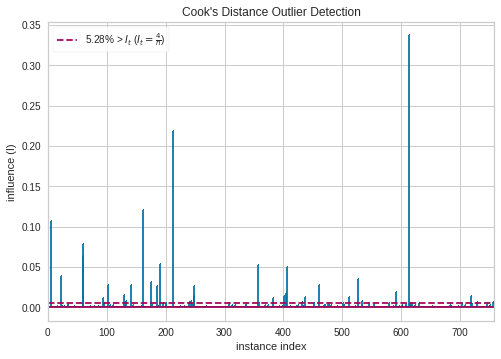

In [65]:
from yellowbrick.regressor import CooksDistance
X = df_analysis[["EPSP", "OPM", "LongFinancialLeverage", "small?", "medium?"]]
x = sm.add_constant(X)
y = df_analysis["ReturnOnNextQuarter"]
m = sm.OLS(y, X).fit()
influence_values = m.get_influence()
l = influence_values.hat_matrix_diag

# Instantiate and fit the visualizer
visualizer = CooksDistance()
visualizer.fit(X, y)
visualizer.show()

Notamos la presencia de valores de distancia de Cock muy elevados. Aquí también se sigue la thumb rule de que una Cook distance superior a 3 veces la media se considera como outlier. Por este motivo utilizaremos la propiedad cook distance de la librería statsmodel para obtener la media y hacer un filtro para excluir outliers.

In [66]:
(cooks, p) = influence_values.cooks_distance
cooks_df = pd.DataFrame(cooks)
cooks_df.columns = ["cooks"]
cooks_df.describe()

,cooks
count,758.000000
mean,0.002447
std,0.016860
min,0.000000
25%,0.000008
50%,0.000094
75%,0.000401
max,0.334272


Vemos que la media de distancia de Cooks es de 0.002447, por lo que estableceremos el límite de tolerancia en 0.007341 de acuerdo a nuestra regla de dedo (los outliers tienen un cook distance mayor a 3 veces la media de cooks distances)



In [67]:
df_analysis["cook"] = cooks


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [68]:
cooks_filter = df_analysis['cook'] <= 0.007341
df_analysis = df_analysis[cooks_filter]
df_analysis

,firm,q,r2,originalprice,ReturnOnNextQuarter,cogs,sgae,otheropexp,revenue,Ebit,...,EPS,lprice,EPSP,Size,pct,small?,medium?,l,leverage,cook
448,SRCE,2022q1,-0.002536,46.25,0.003602,2431.000,0.000,0.000,62049.000,0.0,...,0.0,45.729730,0.0,1.144697e+06,44,0,1,0.004805,0.004805,6.264435e-05
2695,ACTG,2022q1,-0.388320,4.51,-0.293617,0.000,22015.000,0.000,13507.000,0.0,...,0.0,6.650000,0.0,2.096008e+05,16,1,0,0.003997,0.003997,8.092914e-05
3055,AKR,2022q1,0.162206,21.67,-0.307229,0.000,70280.000,-28815.000,81507.000,0.0,...,0.0,18.220675,0.0,2.028246e+06,56,0,1,0.004710,0.004710,2.442261e-05
4135,ACNB,2022q1,0.211581,34.95,0.095438,1024.000,0.000,0.000,18077.000,0.0,...,0.0,28.063857,0.0,3.033382e+05,21,1,0,0.003964,0.003964,3.315088e-04
7645,AFCG,2022q1,-0.009163,19.12,-0.194946,0.000,1144.444,5236.604,16935.738,0.0,...,0.0,18.646623,0.0,3.774850e+05,24,1,0,0.004064,0.004064,1.136086e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318054,WETF,2022q1,-0.043822,5.87,-0.181233,0.000,60679.000,0.000,78368.000,0.0,...,0.0,6.064555,0.0,8.604615e+05,39,0,1,0.004210,0.004210,4.538467e-06
318684,WRLD,2022q1,0.390975,191.84,-0.356033,11043.938,0.000,0.000,166329.470,0.0,...,0.0,129.760000,0.0,1.255824e+06,46,0,1,0.007601,0.007601,7.264322e-06
319044,WSFS,2022q1,-0.055356,46.62,-0.139224,5579.000,0.000,0.000,144137.000,0.0,...,0.0,48.963914,0.0,3.047967e+06,63,0,1,0.004789,0.004789,8.691350e-06
319584,XELB,2022q1,-0.289359,1.49,-0.929759,1680.000,10065.000,32.000,8747.000,-3030.0,...,0.0,1.990000,0.0,2.916097e+04,1,1,0,0.006780,0.006780,4.535171e-03


Después de eliminar los outliers en base al método de Cook distance, nuestro dataset se reduce de 758 a 728 registros.

### DFFITS

El  DFFITS es una medida escalada del cambio en el valor predicho para la i-ésima observación y se calcula eliminando la i-ésima observación. Un valor grande indica que la observación es muy influyente en su vecindad del espacio X.

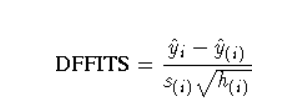

Para DFFITS existe la convención para identificar observaciones influyentes con un valor de corte de 2*sqrt(k/n)., donde K es el número de variables y n es el número de observaciones.  A diferencia de las distancias de Cook, DFFITS puede ser tanto positivo como negativo, pero se desea un valor cercano a 0, ya que estos valores no tendrían influencia en la línea de regresión OLS.

A continuación, utilizaremos la librería statsmodel para poder hallar los valores dffits y excluir los outliers que no estén dentro de la tolerancia convencional para dffits.

In [69]:
# Volvemos a definir el modelo para considerar los ajustes previos con CooksDistance
X = df_analysis[["EPSP", "OPM", "LongFinancialLeverage", "small?", "medium?"]]
x = sm.add_constant(X)
y = df_analysis["ReturnOnNextQuarter"]
m = sm.OLS(y, X).fit()
influence_values = m.get_influence()
l = influence_values.hat_matrix_diag

# Obtenemos los valores de dffits
(dffits, p) = influence_values.dffits


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [70]:
dffits_df = pd.DataFrame(dffits)
dffits_df.columns = ["dffits"]
dffits_df.describe()

,dffits
count,728.000000
mean,-0.003776
std,0.093525
min,-1.527895
25%,-0.015096
50%,0.001742
75%,0.029810
max,0.265336


In [71]:
df_analysis["dffits"] = dffits


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [72]:
import math
k = 5
n = 728
tolerance = 2* math.sqrt(k/n) 
dffits_filter = df_analysis['dffits'] <= tolerance
df_analysis = df_analysis[dffits_filter]
df_analysis

,firm,q,r2,originalprice,ReturnOnNextQuarter,cogs,sgae,otheropexp,revenue,Ebit,...,lprice,EPSP,Size,pct,small?,medium?,l,leverage,cook,dffits
448,SRCE,2022q1,-0.002536,46.25,0.003602,2431.000,0.000,0.000,62049.000,0.0,...,45.729730,0.0,1.144697e+06,44,0,1,0.004805,0.004805,6.264435e-05,0.021760
2695,ACTG,2022q1,-0.388320,4.51,-0.293617,0.000,22015.000,0.000,13507.000,0.0,...,6.650000,0.0,2.096008e+05,16,1,0,0.003997,0.003997,8.092914e-05,-0.046226
3055,AKR,2022q1,0.162206,21.67,-0.307229,0.000,70280.000,-28815.000,81507.000,0.0,...,18.220675,0.0,2.028246e+06,56,0,1,0.004710,0.004710,2.442261e-05,-0.026892
4135,ACNB,2022q1,0.211581,34.95,0.095438,1024.000,0.000,0.000,18077.000,0.0,...,28.063857,0.0,3.033382e+05,21,1,0,0.003964,0.003964,3.315088e-04,0.043404
7645,AFCG,2022q1,-0.009163,19.12,-0.194946,0.000,1144.444,5236.604,16935.738,0.0,...,18.646623,0.0,3.774850e+05,24,1,0,0.004064,0.004064,1.136086e-05,-0.008990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318054,WETF,2022q1,-0.043822,5.87,-0.181233,0.000,60679.000,0.000,78368.000,0.0,...,6.064555,0.0,8.604615e+05,39,0,1,0.004210,0.004210,4.538467e-06,-0.001650
318684,WRLD,2022q1,0.390975,191.84,-0.356033,11043.938,0.000,0.000,166329.470,0.0,...,129.760000,0.0,1.255824e+06,46,0,1,0.007601,0.007601,7.264322e-06,-0.027883
319044,WSFS,2022q1,-0.055356,46.62,-0.139224,5579.000,0.000,0.000,144137.000,0.0,...,48.963914,0.0,3.047967e+06,63,0,1,0.004789,0.004789,8.691350e-06,-0.013897
319584,XELB,2022q1,-0.289359,1.49,-0.929759,1680.000,10065.000,32.000,8747.000,-3030.0,...,1.990000,0.0,2.916097e+04,1,1,0,0.006780,0.006780,4.535171e-03,-1.527895


Vemos una reducción de 728 a 715 registros.

## Análisis de multicolinearidad

La multicolinearidad ocurre cuando hay variables independientes que tienen correlaciones fuertes entre sí. Esto puede causar problemas en la predicción, ya que las variables que se presumen independientes terminan siendo dependientes entre sí. 

Para descartar este problema, se realiza una prueba de multicolinearidad.

In [73]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()

df_analysis= df_analysis.fillna(0)
df_vif  = df_analysis[["EPSP","OPM", "LongFinancialLeverage"]]
vif_data["feature"] = df_vif.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i)
                          for i in range(len(df_vif.columns))]

print(vif_data)

                 feature       VIF
0                   EPSP  1.090616
1                    OPM  1.099034
2  LongFinancialLeverage  1.009248


En la prueba podemos ver que ninguna de las variables tiene un valor superior a 10, por lo tanto podemos descartar que haya problemas de multicolinearidad.

# Creación del modelo

A continuación, utilizaremos álgebra matricial para hacer una regresión lineal múltiple.

Este modelo será construido a partir de los ajustes que se hicieron previamente para tratar las observaciones influenciables, es decir, el dataset para el modelo ya incluye los filtros previamente mostrados para tratar con leverage points y outliers (mediante Cooks Distance y Dffits)

In [74]:
#Definimos las variables dependientes e independientes
X = df_analysis[["EPSP", "OPM", "LongFinancialLeverage", "small?", "medium?"]]

y = df_analysis["ReturnOnNextQuarter"]

In [75]:
#creamos una columna para las betas
X["beta"] = 1
#Hacemos esto para colocar la columna al principio del dataframe
temp_1s_col = X["beta"]
X= X.drop("beta", axis=1)
X.insert(0,"beta", temp_1s_col)
X

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,beta,EPSP,OPM,LongFinancialLeverage,small?,medium?
448,1,0.0,0.000000,0.016016,0,1
2695,1,0.0,0.000000,0.003474,1,0
3055,1,0.0,0.000000,0.404709,0,1
4135,1,0.0,0.000000,0.012156,1,0
7645,1,0.0,0.000000,0.218182,1,0
...,...,...,...,...,...,...
318054,1,0.0,0.000000,0.319127,0,1
318684,1,0.0,0.000000,0.640112,0,1
319044,1,0.0,0.000000,0.018014,0,1
319584,1,0.0,-0.346404,0.258356,1,0


In [76]:
#Obtenemos la transpuesta de X
transposed_X = X.transpose()

In [77]:
# Obtenemos el producto punto entre la transpuesta de X y X
transposed_X_dot_X = transposed_X.dot(X)

In [78]:
#Obtenemos la inversa de la matriz que calculamos previamente
transposed_X_dot_X_inv = np.linalg.inv(transposed_X_dot_X)

In [79]:
#Obtenemos el producto punto entre la transpuesta de X y Y
transposed_X_dot_Y = transposed_X.dot(y)

In [80]:
#Finalmente, obtenemos la matriz de betas calculando el producto punot
#entre las dos últimas matrices que calculamos.
betas = transposed_X_dot_X_inv.dot(transposed_X_dot_Y)

In [81]:
betas

array([-0.0737685 , 20.0982381 ,  0.99321205, -0.2603145 , -0.02902282,
       -0.02674066])

In [82]:
#Validamos el resultado obtenido utilizando la librería OLS de statsmodel
import statsmodels.api as sm

X = df_analysis[["EPSP", "OPM", "LongFinancialLeverage", "small?", "medium?"]]
x = sm.add_constant(X)
y = df_analysis["ReturnOnNextQuarter"]
#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     ReturnOnNextQuarter   R-squared:                       0.044
Model:                             OLS   Adj. R-squared:                  0.037
Method:                  Least Squares   F-statistic:                     6.503
Date:                 Fri, 25 Nov 2022   Prob (F-statistic):           6.34e-06
Time:                         18:41:15   Log-Likelihood:                -94.109
No. Observations:                  715   AIC:                             200.2
Df Residuals:                      709   BIC:                             227.7
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const               

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
